In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
desired_width = 360
pd.set_option('display.width', desired_width)

from IPython.display import display, HTML
import datetime

display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
</style>
"""))
plt.rcParams['figure.figsize'] = [16,4]

In [2]:
trainDt = pd.read_csv('kc_house_train_data2.csv')
testDt = pd.read_csv('kc_house_test_data2.csv')

len(trainDt), len(testDt)

(17384, 4229)

In [3]:
example_features, example_output = (trainDt['sqft_living'], trainDt['price'])  # the [] around 'sqft_living' makes it a list

In [4]:
#print (example_features[:]) # this accesses the first row of the data the ':' indicates 'all columns'
print (example_output.loc[0]) # and the corresponding output

221900.0


# Predicting output given regression weights

Suppose we had the weights [1.0, 1.0] and the features [1.0, 1180.0] and we wanted to compute the predicted output 1.0\*1.0 + 1.0\*1180.0 = 1181.0 this is the dot product between these two arrays. If they're numpy arrayws we can use np.dot() to compute this:

In [5]:
my_weights = np.array([1.]) # the example weights
my_features = example_features[0] # we'll use the first data point
predicted_value = np.dot(my_features, my_weights)
print (predicted_value)

[1180.]


In [6]:
a = np.array([2])
b = np.array([[1,2,3],[1,2,3]])
b*a

array([[2, 4, 6],
       [2, 4, 6]])

In [7]:
len(example_features)

17384

In [97]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)      

    return(predictions)

In [98]:
c = 2
a = np.array([1,2])
b = np.array([[2,1,3],[3,4,6]])
b.transpose()*a, np.matmul(b.transpose(),a), c*a, np.dot(a,b)

(array([[ 2,  6],
        [ 1,  8],
        [ 3, 12]]), array([ 8,  9, 15]), array([2, 4]), array([ 8,  9, 15]))

In [99]:
##If you want to test your code run the following cell:
test_predictions = predict_output(example_features, my_weights)
print (test_predictions[0]) # should be 1181.0
print (test_predictions[1]) # should be 2571.0

0.0
0.0


# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output.

Since the derivative of a sum is the sum of the derivatives we can compute the derivative for a single data point and then sum over data points. We can write the squared difference between the observed output and predicted output for a single point as follows:

(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)^2

Where we have k features and a constant. So the derivative with respect to weight w[i] by the chain rule is:

2\*(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)\* [feature_i]

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

2\*error\*[feature_i]

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. In the case of the constant then this is just twice the sum of the errors!

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors. 

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).

In [100]:
def feature_derivative(errors, feature):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)
    # compute twice the dot product of these vectors as 'derivative' and return the value
    derivative = 2*np.dot(errors,feature)

    return(derivative)

In [101]:
##To test your feature derivartive run the following:
trainDt['constant'] = 1
(example_features, example_output) = trainDt[['constant','sqft_living']], trainDt['price'] 
my_weights = np.array([0., 0.]) # this makes all the predictions 0
test_predictions = predict_output(example_features, my_weights) 
# just like SFrames 2 numpy arrays can be elementwise subtracted with '-': 
errors = test_predictions - example_output # prediction errors in this case is just the -example_output
feature = example_features.iloc[:,0] # let's compute the derivative with respect to 'constant', the ":" indicates "all rows"
derivative = feature_derivative(errors, feature)
print (derivative)
print (-np.sum(example_output)*2) # should be the same as derivative

-18752698920.0
-18752698920.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude (length) of the gradient vector to be smaller than a fixed 'tolerance'.

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent we update the weight for each feature befofe computing our stopping criteria

In [102]:
from math import sqrt # recall that the magnitude/length of a vector [g[0], g[1], g[2]] is sqrt(g[0]^2 + g[1]^2 + g[2]^2)

In [125]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False 
    gradient_lst = []
    ctr = 0
    weights = np.array(initial_weights) # make sure it's a numpy array
    while (not converged):
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        prediction = predict_output(feature_matrix, weights)

        # compute the errors as predictions - output
        error = prediction - output

        gradient_sum_squares = 0 # initialize the gradient sum of squares
        # while we haven't reached the tolerance yet, update each feature's weight
        for i in range(0,len(weights)): # loop over each weight
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            derivative = feature_derivative(error, feature_matrix.iloc[:,i])
            #print("***", derivative)
            # add the squared value of the derivative to the gradient sum of squares (for assessing convergence)
            gradient_sum_squares += derivative * derivative

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - step_size*derivative
            
        # compute the square-root of the gradient sum of squares to get the gradient magnitude:
        print (derivative)
        gradient_magnitude = sqrt(gradient_sum_squares)
        ctr +=1
        if gradient_magnitude < 0.001*tolerance:
            converged = True
            print ("yes1")
        gradient_lst.append(gradient_magnitude)
        if ctr >3:
            print ("***",np.gradient(gradient_lst)[ctr-1])
            if abs(np.gradient(gradient_lst)[ctr-1]) < 0.05:
                converged = True
                print("yes2")
    print (weights, ctr)
    plt.rcParams['figure.figsize'] = [8,4]
    plt.plot(gradient_lst)
    plt.semilogy()
    return(weights, gradient_lst)

A few things to note before we run the gradient descent. Since the gradient is a sum over all the data points and involves a product of an error and a feature the gradient itself will be very large since the features are large (squarefeet) and the output is large (prices). So while you might expect "tolerance" to be small, small is only relative to the size of the features. 

For similar reasons the step size will be much smaller than you might expect but this is because the gradient has such large values.

In [126]:
np.gradient([22,23,22,21,20,19,17,15,13,12,11.5,11,10.75,10.70])

array([ 1.   ,  0.   , -1.   , -1.   , -1.   , -1.5  , -2.   , -2.   ,
       -1.5  , -0.75 , -0.5  , -0.375, -0.15 , -0.05 ])

# Running the Gradient Descent as Simple Regression

First let's split the data into training and test data.
Although the gradient descent is designed for multiple regression since the constant is now a feature we can use the gradient descent function to estimat the parameters in the simple regression on squarefeet. The folowing cell sets up the feature_matrix, output, initial weights and step size for the first model:

In [127]:
# let's test out the gradient descent
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7
(feature_matrix1, output) = trainDt[['constant','sqft_living']], trainDt['price']

-50551526703218.0
13127449965992.049
-3408995808231.925
885263508533.5999
*** -2523732502956.013
-229889247469.85538
*** -655374314517.1425
59698683181.420235
*** -170190577495.73657
-15502825425.72649
*** -44195861846.81891
4025843756.270205
*** -11476982022.998116
-1045449720.1926508
*** -2980394653.959914
271486794.26355094
*** -773961856.4304986
-70501258.91878235
*** -200983777.10984161
18307751.41470611
*** -52184097.57579823
-4754575.600393087
*** -13519712.954772856
1234354.1935240626
*** -3398965.60300644
-320878.2869159579
*** -664959.8235619328
82991.54316693544
*** -68251.86055875884
-21887.213193893433
*** -4855.392611172865
5348.17870464921
*** -328.73327472177334
-1724.4269473552704
*** -22.19901112478692
112.2175358235836
*** -1.5217275931499898
-364.72890254855156
*** -0.12730991013813764
-240.87130641937256
*** -0.03327462263405323
yes2
[-46999.88721194    281.91214561] 22


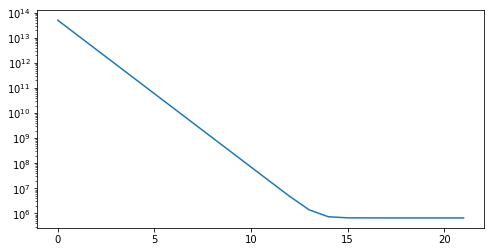

In [128]:
##Next run your gradient descent with the above parameters.

weights1, grad_lst = regression_gradient_descent(feature_matrix1, output, initial_weights, step_size, tolerance)

In [129]:
np.gradient(grad_lst)

array([-3.74240798e+13, -2.35712674e+13, -6.12109372e+12, -1.58955341e+12,
       -4.12782446e+11, -1.07193220e+11, -2.78364219e+10, -7.22868834e+09,
       -1.87717826e+09, -4.87472817e+08, -1.26583937e+08, -3.28519053e+07,
       -8.45933928e+06, -2.03196271e+06, -3.66605842e+05, -3.65536266e+04,
       -2.59206294e+03, -1.75466143e+02, -1.18603694e+01, -8.24518752e-01,
       -8.02922664e-02, -3.32746226e-02])

How do your weights compare to those achieved in week 1 (don't expect them to be exactly the same)? 

**Quiz Question: What is the value of the weight for sqft_living -- the second element of ‘simple_weights’ (rounded to 1 decimal place)?**

In [130]:
weights1

array([-46999.88721194,    281.91214561])

Use your newly estimated weights and your predict_output() function to compute the predictions on all the TEST data (you will need to create a numpy array of the test feature_matrix and test output first:

In [131]:
testDt['constant'] = 1
(feature_matrixtest1, outputtest) = testDt[['constant','sqft_living']], testDt['price']

In [132]:
##Now compute your predictions using test_simple_feature_matrix and your weights from above.
predict_y = predict_output(feature_matrixtest1, weights1)

In [133]:
err = outputtest - predict_y
RSS = sqrt(np.matmul(predict_y,predict_y))
RSS

38793294.26296487

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 1 (round to nearest dollar)?**

In [134]:
round(predict_y[0]), outputtest[0]

(356134.0, 310000.0)

## Comparing Results with sklearn LinearRegression library

In [135]:
regr = LinearRegression()


In [136]:
regr.fit(trainDt[['constant','sqft_living']], trainDt['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [137]:
regr.coef_

array([  0.        , 281.95883963])

In [141]:
regr.predict(testDt[['constant','sqft_living']]), testDt['price'][0]

(array([356085.0615985 , 784662.49783662, 435033.53669499, ...,
        663420.19679557, 604208.8404732 , 240481.93735006]), 310000.0)

# Running a multiple regression

Now we will use more than one actual feature. Use the following code to produce the weights for a second model with the following parameters:

In [142]:
(feature_matrix2, output) = trainDt[['constant','sqft_living', 'sqft_living15']], trainDt['price']
step_size = 4e-12
tolerance = 1e9

-48982259336010.0
15855847010524.691
-4270003460070.5547
1956834765050.774
*** -4785112186902.827
10520533772.547138
*** -1346698285951.482
599537133451.5693
*** -272676678773.3551
402546262189.83765
*** -45692073199.41162
449681828888.1297
*** -17536586643.0542
421430730647.87103
*** -14372845334.459839
416884893753.0186
*** -13760244120.388794
405302415894.28973
*** -13406994890.49878
396210675588.73267
*** -13086258693.802185
386647359058.4592
*** -12775510315.622986
377524113482.0249
*** -12472369159.57788
368551212541.8159
*** -12176443508.897095
359811711824.36487
*** -11887541352.956665
351273206815.49725
*** -11605493999.3609
342939261602.0257
*** -11330138606.953308
334802438193.8493
*** -11061316380.365662
326858861239.4713
*** -10798872309.806946
319103697087.15063
*** -10542655065.06549
311532552513.4042
*** -10292516906.605713
304141037497.4316
*** -10048313600.223999
296924897513.4211
*** -9809904333.861023
289879969260.52844
*** -9577151636.4057
283002191232.11194
*** -9

2161836280.8197546
*** -71423481.9165473
2110543902.6227567
*** -69728867.03376484
2060468502.5925508
*** -68074459.08207273
2011581206.3492324
*** -66459304.10019302
1963853824.5809808
*** -64882470.758481026
1917258836.8144736
*** -63343049.8274312
1871769375.537017
*** -61840153.649018764
1827359210.7006612
*** -60372915.62402439
1784002734.596479
*** -58940489.720178604
1741674947.0962608
*** -57542049.97186518
1700351441.2206328
*** -56176790.01446009
1660008389.0909789
*** -54843922.61236954
1620622528.1799908
*** -53542679.21356201
1582171147.8729274
*** -52272309.49383402
1544632076.406774
*** -51032080.938051224
1507983668.080392
*** -49821278.40521288
1472204790.74809
*** -48639203.726632595
1437274813.661989
*** -47485175.29515576
1403173595.5646257
*** -46358527.678412676
1369881473.076353
*** -45258611.2301929
1337379249.3497255
*** -44184791.71833992
1305648183.0218482
*** -43136449.959383965
1274669977.369154
*** -42112981.46093035
1244426769.8027647
*** -41113796.071711

6319619.007059097
*** -207511.46155314334
6169667.931700826
*** -202526.53022195958
6023274.6376776695
*** -197658.43797799665
5880354.7196599245
*** -192904.3814388672
5740825.756175995
*** -188261.62565688696
5604607.303193718
*** -183727.4970265953
5471620.804351866
*** -179299.38638056256
5341789.591499716
*** -174974.7468124088
5215038.7836229205
*** -170751.09059094545
5091295.305597514
*** -166625.98756095022
4970487.799520552
*** -162597.0670616692
4852546.6162029505
*** -158662.01411930006
4737403.729063243
*** -154818.56603275798
4624992.76824373
*** -151064.51555366442
4515248.895282
*** -147397.70869913697
4408108.840673178
*** -143816.03802317474
4303510.823658019
*** -140317.4505214626
4201394.524202824
*** -136899.94096003007
4101701.0720255673
*** -133561.5484245587
4004372.9737547934
*** -130300.3610828314
3909354.112735927
*** -127114.51358645223
3816589.695608735
*** -124002.18250875548
3726026.237594515
*** -120961.58804383967
3637611.5149514675
*** -117990.99376408

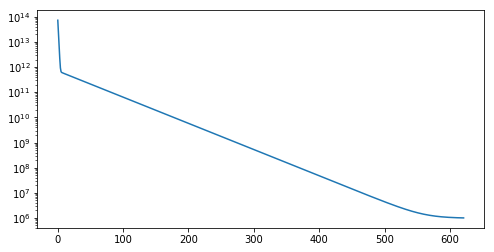

In [143]:
## Use the above parameters to estimate the model weights. Record these values for your quiz.
initial_weights = [-100000., 1., 1.]
weights2, grad_lst = regression_gradient_descent(feature_matrix2, output, initial_weights, step_size, tolerance)

Use your newly estimated weights and the predict_output function to compute the predictions on the TEST data. Don't forget to create a numpy array for these features from the test set first!

In [144]:
feature_matrixtest2, outputtest = testDt[['constant','sqft_living', 'sqft_living15']], testDt['price']
predict_y = predict_output(feature_matrixtest2, weights2)

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 2 (round to nearest dollar)?**

In [145]:
predict_y[0], outputtest[0]

(366595.4976357749, 310000.0)

In [146]:
err = outputtest - predict_y
RSS = sqrt(np.matmul(predict_y,predict_y))
RSS

38861201.43961257